# Parameter estimation with MCMC - comparison across strains.

In [1]:
import os
import glob
import pickle
import datetime
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special
import numba
# Library to perform MCMC runs
import emcee
import matplotlib.gridspec as gridspec
import sys
sys.path.append(os.path.abspath('../'))
import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import seaborn as sns
import corner

mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Generate a variable with the day that the script is run
today = str(datetime.datetime.today().strftime('%Y%m%d'))

# Defining the problem

In this notebook we will perform Bayesian parameter estimation of the dissociation constants of the inducer binding to the repressor in the active and inactive state, or $K_A$ and $K_I$, respectively. While the main text of the paper estimated these values from measurements of fold-change from a strain containing the O2 operator and $R=260$ per cell, here we consider this inference for each of the individual strains. Specifically, we make multiple estimates of $K_A$ and $K_I$ by applying parameter estimation using the fold-change measurements as a function of inducer concentration, $c$, for each combination of operator binding energy and LacI copy number considered. Following parameter estimation from each strain's dataset, we then compare the theoretical predictions with our experimental data in a similar manner to that of the main text. 

For details of the parameter estimation and the Bayesian approach that is applied here, see the 'MCMC_Parameter_estimation' notebook. 


# Load in all the fold-change data from all strains

In [24]:
datadir = '../../data/'
# read the list of data-sets to ignore
data_ignore = pd.read_csv(datadir + 'datasets_ignore.csv', header=None).values
# read the all data sets except for the ones in the ignore list
all_files = glob.glob(datadir + '*' + '_IPTG_titration_MACSQuant' + '*csv')
ignore_files = [f for f in all_files for i in data_ignore if i[0] in f]
read_files = [f for f in all_files if f not in ignore_files and 'dimer' not in f]
print('Number of unique data-sets: {:d}'.format(len(read_files)))
df = pd.concat(pd.read_csv(f, comment='#') for f in read_files)

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]
# Restart index
df = df.reset_index()

df.head()

Number of unique data-sets: 35


index      date  username operator  binding_energy      rbs  repressors  \
0      2  20160804  mrazomej       O2           -13.9    RBS1L         870   
1      3  20160804  mrazomej       O2           -13.9     RBS1         610   
2      4  20160804  mrazomej       O2           -13.9  RBS1027         130   
3      5  20160804  mrazomej       O2           -13.9   RBS446          62   
4      6  20160804  mrazomej       O2           -13.9  RBS1147          30   

   IPTG_uM   mean_YFP_A  mean_YFP_bgcorr_A  fold_change_A  
0      0.0  3624.474605         111.851286       0.007146  
1      0.0  3619.786265         107.162946       0.006847  
2      0.0  3717.019527         204.396208       0.013059  
3      0.0  3854.650585         342.027265       0.021853  
4      0.0  4169.802851         657.179531       0.041988

# Perform parameter estimation of $K_A$ and $K_I$ from each strain's fold-change measurements.

First we have to define the function to compute the log probability distribution.

In [3]:
def log_likelihood(param, indep_var, dep_var):
    """
    Computes the log likelihood probability.
    Parameteres
    -----------
    param : data-frame.
        The parameters to be fit by the MCMC. This must be an array of length 3
        with the following entries
        param[0] = ea == -lnKa
        param[1] = ei == -lnKi
        param[2] = sigma. Homoscedastic error associated with the Gaussian 
        likelihood.
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    epsilon : float.
        Energy difference between the active and inactive state of the repressor.
    Returns
    -------
    log_like : float.
        the log likelihood.
    """
    # unpack parameters
    ea, ei, sigma = param
    #ei =  np.log(1000)+ea 
    
    
    # unpack independent variables
    IPTG, R, epsilon_r = indep_var.iloc[:, 0],\
                         indep_var.iloc[:, 1],\
                         indep_var.iloc[:, 2]
    
    # compute the theoretical fold-change
    fc_theory = mwc.fold_change_log(IPTG, ea, ei,4.5, R, epsilon_r)
   
    log_like =  np.sum((fc_theory - dep_var)**2) / 2 / sigma**2
    return log_like
   
def log_post(param, indep_var, dep_var,
             ea_range=[6 -6], ei_range=[6, -6], sigma_range=[0, 1]):
    '''
    Computes the log posterior probability.
    Parameters
    ----------
    param : array-like.
        The parameters to be fit by the MCMC. This must be an array of length 3
        with the following entries
        param[0] = ea == -lnKa
        param[1] = ei == -lnKi
        param[2] = sigma. Homoscedastic error associated with the Gaussian 
        likelihood.
    indep_var : n x 3 array.
        Series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        Dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    ea_range : array-like.
        Range of variables to use in the prior as boundaries for the ea parameter.
    ei_range : array-like.
        Range of variables to use in the prior as boundaries for the ei parameter.
    sigma_range : array-like.
        Range of variables to use in the prior as boundaries for the sigma param.
    '''
    # unpack parameters
    ea, ei, sigma = param
    #ei =  np.log(1000) + ea 
    
    # Set the prior boundaries. Since the variables have a Jeffreys prior, in
    # the log probability they have a uniform prior
    if ea > np.max(ea_range) or ea < np.min(ea_range)\
    or ei > np.max(ei_range) or ei < np.min(ei_range)\
    or sigma > np.max(sigma_range) or sigma < np.min(sigma_range):
        return -np.inf

    
    return -(len(indep_var) + 1) * np.log(sigma) \
    - log_likelihood(param, indep_var, dep_var)

In [4]:
# Determine the unique combinations of operator and LacI copy
# number in our data for us to loop through.
groups = df.groupby(['operator', 'rbs'])

# Loop through each combination of operator and LacI copy
# number. Perform the parameter estimation for each dataset
# Note that teach of these consists of fold-change measurements 
# from a single strain and different inducer concentrations.
for g, subdata in groups:
    
    # Grab data for parameter estimation
    df_temp = df[(df.operator == g[0]) & (df.rbs ==  g[1])]
    indep_var = df_temp[['IPTG_uM', 'repressors', 'binding_energy']]
    dep_var = df_temp.fold_change_A
    
    # Perform a non-linear regression 
    # Note that to initialize the walkers we use a non-linear regression 
    # approach to find the most probable parameter values and then initialize 
    # the walkers within that region using `numpy`'s `multivariate_normal` sampler.
    map_param =  mwc.non_lin_reg_mwc(df_temp, p0=[-5, 2], diss_const=False)
    mean = [map_param[0], map_param[2]]
    cov = np.array([[map_param[1], 0], [0, map_param[3]]])
    
    #Define the parameters for emcee
    n_dim = 3 # number of parameters to fit

    n_walkers = 50
    n_burn = 500
    n_steps = 5000

    # Initialize walkers
    p0 = np.empty((n_walkers, n_dim))
    p0[:,[0, 1]] = np.random.multivariate_normal(mean, cov, n_walkers)
    p0[:,2] = np.random.uniform(1E-5, 0.2, n_walkers)
    
    # Set the ranges for the MCMC
    ea_range = [-7, 7]
    ei_range = [-7, 7]
    sigma_range = [0, df.groupby('rbs').fold_change_A.std().max()]

    #Call the sampler. 
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                    args=(indep_var, dep_var, ea_range, ei_range, sigma_range),\
                    threads=6)
    
    #Do the burn in 
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    
    sample = True
    if sample:
        # Perform the real MCMC
        _ = sampler.run_mcmc(pos, n_steps)
        output = open('../../data/mcmc/' + today + \
                      '_gauss_homoscedastic_' + g[0] + '_' + g[1] + '.pkl', 'wb')
        pickle.dump(sampler.flatchain, output)
        pickle.dump(sampler.flatlnprobability, output)
   
    output.close() # close it to make sure it's all been written

KeyboardInterrupt: 

Lets take a look at one of the strains:

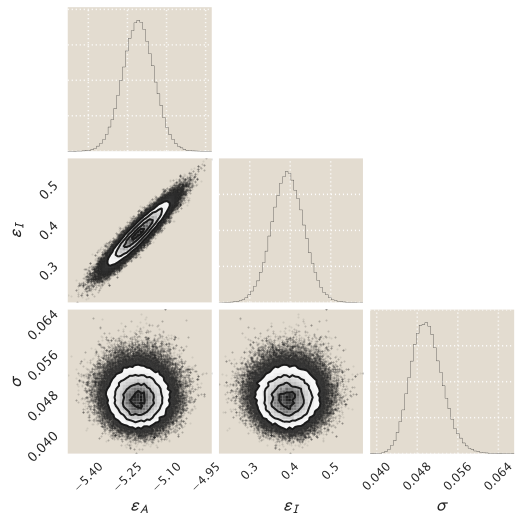

In [27]:
# Load the flat-chain
with open('../../data/mcmc/' + '20170109' + \
                  '_gauss_homoscedastic_O1_rbs1027.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Draw the corner plot
fig = corner.corner(gauss_flatchain, bins=50, 
                    plot_contours=True,
                    labels=[r'$\epsilon_A$', r'$\epsilon_I$', r'$\sigma$'])
fig.savefig('../../data/mcmc/' + '20170109' + \
          '_corner_plot' + 'O1_rbs1027' + '.pdf')

## Determinine credible region using MCMC traces

To report the output of the MCMC routine we will use the HPD. As explained in [this tutorial](http://bebi103.caltech.edu/2015/tutorials/l06_credible_regions.html)
>This method uses the highest posterior density interval, or HPD. If we're considering a 95% confidence interval, the HPD interval is the shortest interval that contains 95% of the probability of the posterior. So, we report the mode and then the bounds on the HPD interval.

We will use the same funciton used in the tutorial to compute the HPD from the MCMC chain. Now that we not only know the MAP value of the MWC parameters, but also the credible intervals for them we can properly reflect that uncertainty on our plots.

Drawing a proper credible region on the fold-change curve is not as straight forwared as taking both lower and upper boundaries of the HPD and plotting these values since, as shown in the MCMC trace plot the paraemeters are clearly correlated. But we can take advantage of the MCMC traces to compute the proper credible intevals. We use the function 'mcmc_cred_region' in our mwc_utils to calculate this credible region.

Now lets calculate the HPD from the MCMC traces for each of our strains. We'll create a new Pandas DataFrame to save these in for plotting.

In [9]:
# generate DataFrame to save parameter estimates
param_summary = pd.DataFrame(columns=['rbs','operator', 'Ka', 'Ka_hpd',
                                      'Ki', 'Ki_hpd'])
# Loop through each strain in groups and calculate HPD
groups = df.groupby(['operator', 'rbs'])
for g, subdata in groups:
    if g[0] == 'Oid':
        continue
    with open('../../data/mcmc/' + '20170109' + \
              '_gauss_homoscedastic_' + g[0] + '_' + g[1] + '.pkl', 'rb') as file:
        unpickler = pickle.Unpickler(file)
        gauss_flatchain = unpickler.load()
        gauss_flatlnprobability = unpickler.load()
    
    # map value of the parameters
    max_idx = np.argmax(gauss_flatlnprobability, axis=0)
#    ea, ei, sigma = gauss_flatchain[max_idx]
    ea, ei = gauss_flatchain[max_idx, [0, 1]]
    Ka, Ki = np.exp(-ea), np.exp(-ei)

    # ea range
    ea_hpd = mwc.hpd(gauss_flatchain[:, 0], 0.95)
    ei_hpd = mwc.hpd(gauss_flatchain[:, 1], 0.95)
    Ka_hpd = np.exp(-ea_hpd)
    Ki_hpd = np.exp(-ei_hpd)
              
    # add values to dataframe
    param_summary_temp = pd.DataFrame({'rbs':g[1],'operator':g[0],
                                   'Ka':[Ka],
                                   'Ka_hpd':[[Ka_hpd[0],Ka_hpd[1]]], 
                                   'Ki':[Ki],
                                   'Ki_hpd':[[Ki_hpd[0],Ki_hpd[1]]]})

    param_summary = param_summary.append(param_summary_temp, ignore_index=True)

In [10]:
param_summary.head()

Ka                          Ka_hpd        Ki  \
0  711.965289  [1096.59380583, 309.622973936]  0.827068   
1  133.275942  [150.559859865, 118.177539937]  0.435608   
2  181.893926  [205.611316954, 162.249054651]  0.672515   
3  230.657217   [279.78313649, 195.546499692]  0.875926   
4  137.543746  [162.055216095, 118.162070948]  0.386748   

                             Ki_hpd operator      rbs  
0  [0.897512398348, 0.727282437321]       O1    HG104  
1  [0.479536611702, 0.393834538683]       O1     RBS1  
2  [0.729369047518, 0.623358306666]       O1  RBS1027  
3  [0.940233866922, 0.816317917998]       O1  RBS1147  
4   [0.441955326608, 0.34172328623]       O1    RBS1L

# Plot the results

Here we will want to plot the parameter estimates of $K_A$ and $K_I$. We will also want to use these parameter estimates to predict fold-change as a function of operator binding energy and LacI copy number. Due to the many possible combinations of operator and LacI copy number, we consider each set of strains with a common operator.

In [28]:
# Pick operator to look at.
op = 'O3'
df = df[df.operator==op]
param_summary_op= param_summary[param_summary.operator==op]

Lets plot the estimates of $K_A$ and $K_I$. Note that I also would like to include the inferred values for $K_A$ and $K_I$ from the global inference. From the MCMC_parameter_estimation notebook, we found:


Ka = 139.55 +46.894 -27.525 uM

Ki = 0.535 +0.113 -0.075 uM

In [19]:
# Lets define these to use in our plots.
# They've been taken from the MCMC_parameter_estimation
# notebook.
Ka_global = 139.55
Ka_global_range = [(139.55-27.525),(139.55+46.894)]
Ki_global = 0.535
Ki_global_range = [(0.535-0.113),(0.535+0.075)]

Lets start by plotting the inferred values for $K_A$ and $K_I$ across each strain with a different copy number of LacI.

In [29]:
# Define array of IPTG concentrations
IPTG = np.logspace(-9, -1, 200)

# current default color palette
colors = sns.color_palette('colorblind', n_colors=8)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]
gs_dict = {'hspace': 0.1, 'wspace':0.1}

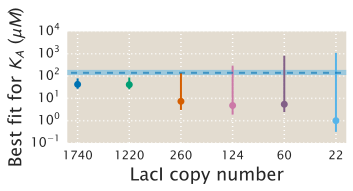

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,2), gridspec_kw=gs_dict)


for i, rbs_fit in enumerate(df.rbs.unique()):
    Ka = param_summary_op[param_summary_op['rbs']==rbs_fit].Ka
    Ka_hpd = param_summary_op[param_summary_op['rbs']==rbs_fit].Ka_hpd

    plt.errorbar(i,Ka, 
                 yerr=[np.abs(Ka-Ka_hpd.values[0][1]),np.abs(Ka-Ka_hpd.values[0][0])],
                 fmt='o', color=colors[i])

# Lets also plot the global best value of Ki using all 
# data across all operators
plt.plot(np.arange(-2,7),np.ones(9)*Ka_global, linestyle='--',alpha=0.6)
plt.fill_between(np.arange(-2,7) , Ka_global_range[0], Ka_global_range[1],
                         alpha=0.5, color=colors[i])

ax.set_yscale('log')
plt.xticks(np.arange(0,6), 2*df.repressors.unique())#, rotation='vertical')
plt.xlim(-0.2,5.2)
plt.ylim(1E-1,1E4)
plt.ylabel('Best fit for $K_A$ ($\mu M$)')
plt.xlabel('LacI copy number')
plt.savefig('../../data/mcmc/' + '20170109' + \
           '_Ka_summary_' + op + '_slim_wglobal.pdf',bbox_inches='tight')

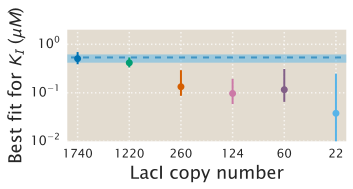

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,2), gridspec_kw=gs_dict)

for i, rbs_fit in enumerate(df.rbs.unique()):
    
    Ki = param_summary_op[param_summary_op['rbs']==rbs_fit].Ki
    Ki_hpd = param_summary_op[param_summary_op['rbs']==rbs_fit].Ki_hpd

    plt.errorbar(i,Ki, 
                 yerr=[np.abs(Ki-Ki_hpd.values[0][1]),np.abs(Ki-Ki_hpd.values[0][0])],
                 fmt='o', color=colors[i])

# Lets also plot the global best value of Ki using all 
# data across all operators
plt.plot(np.arange(-2,7),np.ones(9)*Ki_global, linestyle='--',alpha=0.6)
plt.fill_between(np.arange(-2,7) , Ki_global_range[0], Ki_global_range[1],
                         alpha=0.5, color=colors[i])

ax.set_yscale('log')
plt.xticks(np.arange(0,6), 2*df.repressors.unique())#, rotation='vertical')
plt.xlim(-0.2,5.2)
plt.ylim(1E-2,2)
plt.ylabel('Best fit for $K_I$ ($\mu M$)')
plt.xlabel('LacI copy number')
plt.savefig('../../data/mcmc/' + '20170109' + \
           '_Ki_summary_' + op + '_slim_wglobal.pdf',bbox_inches='tight')

Now lets plot the fold-change predictions and data using the strain specific estimates of $K_A$ and $K_I$.

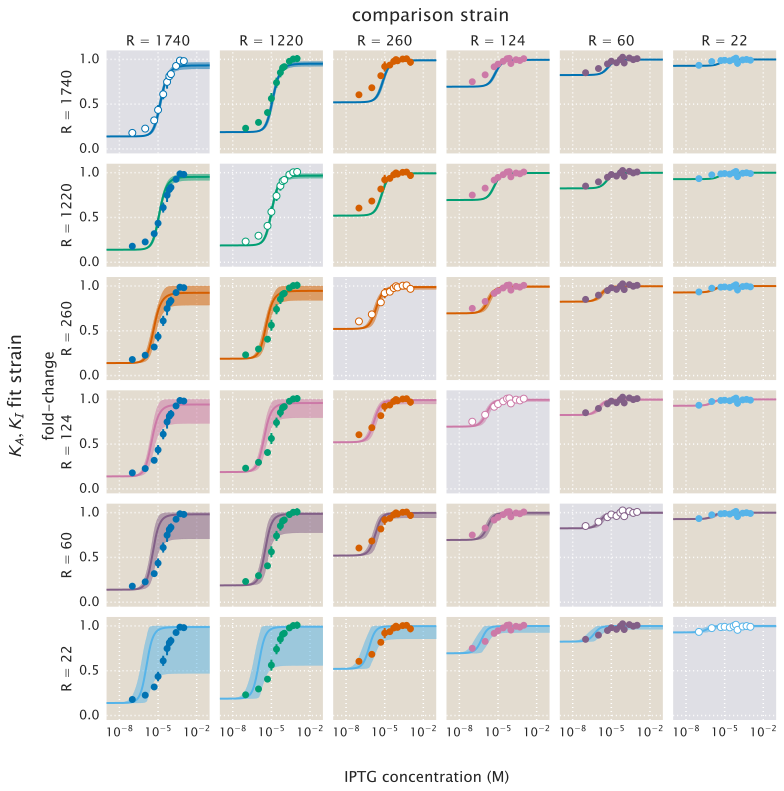

In [32]:

fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(12,12), gridspec_kw=gs_dict)
count = 1
for j, rbs_fit in enumerate(df.rbs.unique()):
    
    with open('../../data/mcmc/' + '20170109' + \
          '_gauss_homoscedastic_' + op + '_' + rbs_fit + '.pkl', 'rb') as file:
        unpickler = pickle.Unpickler(file)
        gauss_pool_flatchain = unpickler.load()

    
    # map value of the parameters
    ea, ei = np.mean(gauss_pool_flatchain[:, [0, 1]], axis=0)

    for i, rbs in enumerate(df.rbs.unique()):
        # plot the theory using the parameters from the fit.
        ax[j,i].plot(IPTG , mwc.fold_change_log(IPTG * 1E6, 
            ea=ea, ei=ei, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique(),
            epsilon_r=df.binding_energy.unique()),
            color=colors[j])
        # plot 95% HPD region using the variability in the MWC parameters
        cred_region = mwc.mcmc_cred_region(IPTG * 1E6, 
            gauss_pool_flatchain, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique(),
            epsilon_r=df.binding_energy.unique())
        ax[j,i].fill_between(IPTG , cred_region[0,:], cred_region[1,:],
                        alpha=0.5, color=colors[j])
        # compute the mean value for each concentration
        fc_mean = df[df.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
        # compute the standard error of the mean
        fc_err = df[df.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
        np.sqrt(df[df.rbs==rbs].groupby('IPTG_uM').size())

        # plot the experimental data
        if i == j:
            ax[j,i].errorbar(np.sort(df[df.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
                yerr=fc_err, linestyle='none', label=rbs, color=colors[i])
            ax[j,i].plot(np.sort(df[df.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
                        'o', markeredgewidth=1, markeredgecolor=colors[i],
                         markerfacecolor='w', markersize=7)
            ax[j,i].set_axis_bgcolor("#DFDFE5")
        else:
            ax[j,i].errorbar(np.sort(df[df.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
                yerr=fc_err, fmt='o', markersize=7, label=rbs, color=colors[i])
               
        if i == 0:
            ax[j,i].set_ylabel('R = %s' %(df[df.rbs==rbs_fit].repressors.unique()[0] * 2), fontsize=14)
        if j == 0:
            ax[j,i].set_title('R = %s' %(df[df.rbs==rbs].repressors.unique()[0] * 2), fontsize=14)
        
        ax[j,i].set_xlim(1E-9, 1E-1)
        ax[j,i].set_ylim(-0.05,1.1) 
        ax[j,i].set_xscale('log')
        ax[j,i].set_xticks([1E-8, 1E-5, 1E-2]) 
        ax[j,i].set_yticks([0, 0.5, 1])
       
        if i > 0 and i < 6 and j < 5:
            ax[j, i].set_xticklabels([])
            ax[j, i].set_yticklabels([])
        if i==0 and j < 5:
            ax[j, i].set_xticklabels([])
        if j==5 and i > 0 and i < 6:
            ax[j, i].set_yticklabels([])

fig.text(0.01, 0.5, '$K_A, K_I$ fit strain', va='center', rotation='vertical',fontsize=18)
fig.text(0.05, 0.5, 'fold-change', va='center', rotation='vertical',fontsize=15)
fig.text(0.4, 0.05, 'IPTG concentration (M)', va='bottom',fontsize=15)
fig.suptitle('comparison strain', y=0.95, fontsize=18)
#plt.savefig('/Users/gchure/Desktop/' + '20160923' + \
#         '_fitcompare_summary' + op + '.pdf',bbox_inches='tight')
plt.savefig('../../data/mcmc/' + '20170109' + \
         '_fitcompare_summary' + op + '.pdf',bbox_inches='tight')